# AR(1) sampling

## Bogumił Kamiński

### Theory

Let us create a simple AR(1) process simulator, to see
some story - not just dry definitions. For completeness we will first
introduce a bit of theory of such processes, next we will discuss how you can
define your own module, and finally we will show how we can use it.

The AR(1) model is a random process $X_t$, where $t\in\mathbb{Z}$, and the
support of random variables $X_t$ is $\mathbb{R}$, that follows the equation:

$$
X_t = c + \phi X_{t-1} + \varepsilon_t,
$$

where $\varepsilon_i$ are independent random variables that are normally
distributed with mean $0$ and variance $\sigma^2$.

For the AR(1) process to be stationary we assume $|\phi|<1$.
Also clearly we have $\sigma\geq0$, as standard deviation must be non-negative.

We will want to create a simulator of this process in Julia.

In order to implement it we need to derive the distribution of the unconditional
mean and variance of $X_t$. It is simplest to get them assuming they exist and
are independent from $t$ (they do as we take $|\phi|<1$; I omit some
technical details here).

For expected value we get:

$$
E(X_t) = E(c + \phi X_{t-1} + \varepsilon_t) = c + \phi E(X_{t-1}).
$$

but as the process is stationary $E(X_t)=E(X_{t-1})$ so after substituting
$E(X_t) = c / (1 - \phi)$.

For variance we get:

$$
D^2(X_t) = D^2(c + \phi X_{t-1} + \varepsilon_t) = \phi^2 D^2(X_{t-1}) + \sigma^2,
$$

where we have used the assumption that $\varepsilon_t$ is independent from
$X_{t-1}$.
Again, as the process is stationary $D^2(X_t)=D^2(X_{t-1})$ so after
substituting $D(X_t) = \sigma^2 / (1 - \phi^2)$.

The last question is what is the unconditional distribution of $X_t$. We know
its mean and variance (and they are both finite), so it is easiest to unroll
the AR(1) process definition recursively $s$ times:

$$
X_t = c + \phi X_{t-1} + \varepsilon_t = \ldots = \phi^{s+1}X_{t-s+1} + \sum_{i=0}^s \phi^i (c + \varepsilon_{t-i})
$$

Since we know that $X_{t-s+1}$ has a finite variance we see that if we let
$s\to\infty$ then $X_t$ converges in probability to a normal distribution
(here we use the fact that $\varepsilon_i$ are normally distributed and a sum
of normally distributed variables is also normally distributed). In conclusion
we get that:

$$
X_t \sim \mathcal{N}\left(\frac{c}{1-\phi},\frac{\sigma^2}{1-\phi^2}\right).
$$


### Implementation

We will create a complete module providing an implementation of the AR(1) simulator.

In [1]:
module AR1

using Random

export ar1!, ar1

const AR1_COMMON_DOC = """
elements following the AR(1)
process where `xₜ₊₁ = c + ϕxₜ + εₜ` and `εₜ ∼ N(0, σ²)`.

If `start` keyword argument is passed then this is the first element of the
returned vector. Otherwise it is initiated randomly to follow the stationary
distribution of the process.

You can pass `rng` keyword argument to specify a custom random number generator
that should be used when generating data.

It is required that |ϕ| < 1 so that the process is stationary.
"""

sample_start(c::Real, ϕ::Real, σ::Real, rng::AbstractRNG) =
    c / (1 - ϕ) + randn(rng) * σ / sqrt(1 - ϕ^2)

"""
    ar1!(v, c, ϕ, σ; rng, start)

Update vector `v` in place by filling it with
$AR1_COMMON_DOC
"""
function ar1!(v::AbstractVector{<:AbstractFloat}, c::Real, ϕ::Real, σ::Real;
              rng::AbstractRNG=Random.default_rng(),
              start::Real=sample_start(c, ϕ, σ, rng))
    σ < 0 && throw(ArgumentError("σ is not allowed to be negative"))
    abs(ϕ) < 1 || throw(ArgumentError("|ϕ| < 1 is required"))
    x = start
    n = length(v)
    if n > 0
        v[1] = x
        for i in 2:n
            x = c + x * ϕ + randn(rng) * σ
            v[i] = x
        end
    end
    return v
end

"""
    ar1(n, c, ϕ, σ; rng, start)

Return a vector containing `n`
$AR1_COMMON_DOC
"""
function ar1(n::Integer, c::Real, ϕ::Real, σ::Real;
             rng::AbstractRNG=Random.default_rng(),
             start::Real=sample_start(c, ϕ, σ, rng))
    return ar1!(Vector{Float64}(undef, n), c, ϕ, σ, rng=rng, start=start)
end

end # module

Main.AR1

Visibility of symbols:

In [2]:
AR1

Main.AR1

In [3]:
AR1.ar1

ar1 (generic function with 1 method)

In [4]:
ar1

LoadError: UndefVarError: `ar1` not defined

Difference between local module and a package:

In [5]:
using AR1

LoadError: ArgumentError: Package AR1 not found in current path, maybe you meant `import/using .AR1`.
- Otherwise, run `import Pkg; Pkg.add("AR1")` to install the AR1 package.

In [6]:
using .AR1

Now `ar1` is visible:

In [7]:
ar1

ar1 (generic function with 1 method)

In [8]:
?ar1

search: ar1 ar1! AR1 @macroexpand1



```
ar1(n, c, ϕ, σ; rng, start)
```

Return a vector containing `n` elements following the AR(1) process where `xₜ₊₁ = c + ϕxₜ + εₜ` and `εₜ ∼ N(0, σ²)`.

If `start` keyword argument is passed then this is the first element of the returned vector. Otherwise it is initiated randomly to follow the stationary distribution of the process.

You can pass `rng` keyword argument to specify a custom random number generator that should be used when generating data.

It is required that |ϕ| < 1 so that the process is stationary.


Generate an example AR(1) path:

In [9]:
using Plots

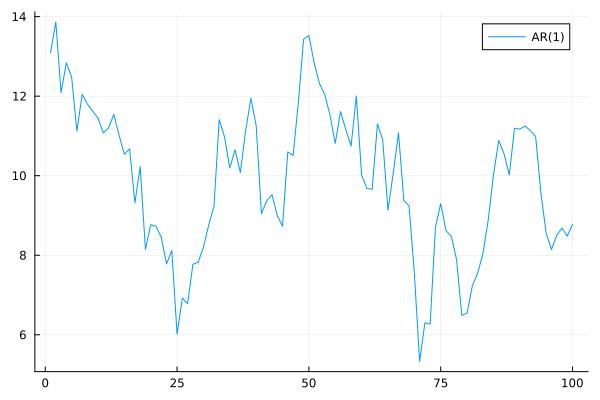

In [10]:
plot(ar1(100, 1, 0.9, 1); label="AR(1)")

Check if indeed $\phi=0.9$ in generated data:

In [11]:
using StatsBase

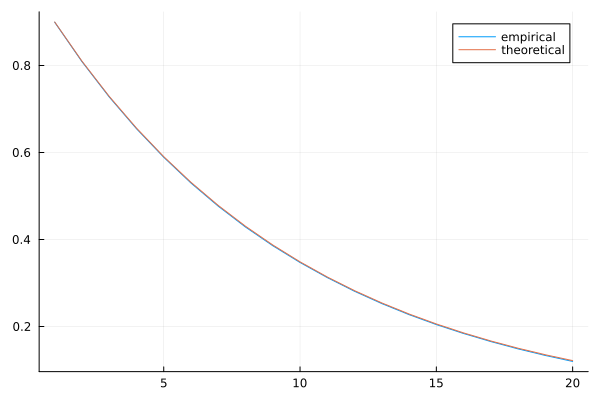

In [12]:
plot([autocor(ar1(10^6, 1, 0.9, 1), 1:20) 0.9 .^ (1:20)]; label=["empirical" "theoretical"])

Let us check why it is important to set `start` properly. Generate 1 million sequences of 10 elements.

The theoretical mean is `1 / (1 - 0.9) = 10` and variance `1/(1−0.9²) = 100 / 19 ≈ 5.26316`.

The default settings (stationary):

In [13]:
using Statistics

In [14]:
sim = sim = [ar1(10, 1, 0.9, 1) for i in 1:10^6]

1000000-element Vector{Vector{Float64}}:
 [8.846378449483582, 8.195824375692618, 7.868389347511938, 7.158718154065734, 8.324087465871656, 8.007468273243378, 7.524084992611614, 6.587234035814889, 5.681217202773914, 5.37291462932142]
 [7.902784241313549, 7.868171054228927, 6.872904200891828, 5.943148576877475, 5.80960543770358, 5.207141660377134, 5.0691364735721525, 7.256824352508581, 6.68480498894388, 6.731489594514383]
 [12.319531986675539, 12.663150475387113, 12.628035509165839, 13.307573412132408, 13.307933734660313, 14.16413761015462, 14.433294047996842, 12.921445179216446, 14.09024077404128, 13.144043784722953]
 [11.006334361077586, 11.563245403355152, 11.179632012074945, 11.741185247514606, 11.758186418357585, 12.159884201561983, 11.398393115369666, 11.850012836975603, 10.517234849838019, 10.09150784191792]
 [11.239310851418628, 9.275626329803096, 10.217629105337245, 8.836053860224672, 8.456513113176907, 8.16092164885069, 9.985392882295214, 9.319070840000578, 9.734535719897433, 9.

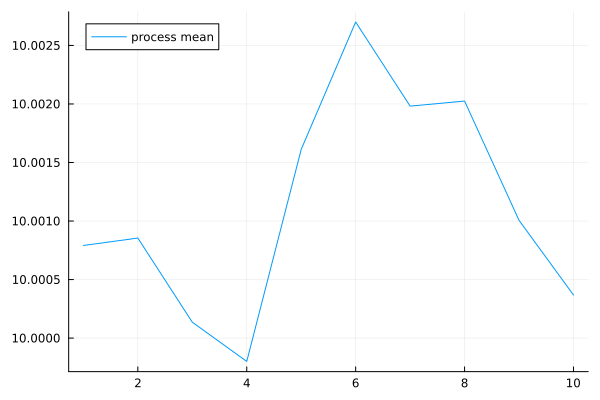

In [15]:
plot([mean(getindex.(sim, i)) for i in 1:10]; label="process mean")

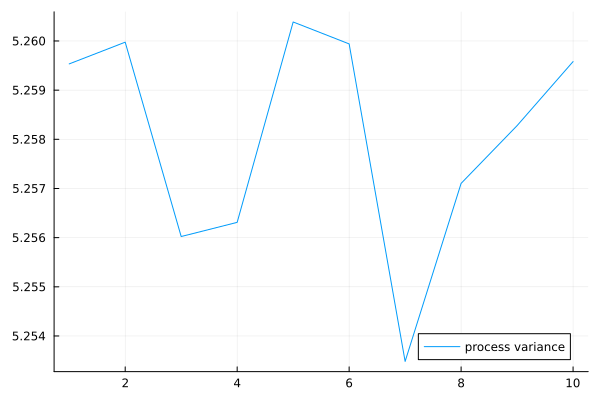

In [16]:
plot([var(getindex.(sim, i)) for i in 1:10]; label="process variance")

Now start the process at `0`:

In [17]:
sim = sim = [ar1(10, 1, 0.9, 1; start=0) for i in 1:10^6]

1000000-element Vector{Vector{Float64}}:
 [0.0, 1.301142524495748, 0.5779007023688836, 4.079124245667262, 4.0180117617568945, 4.974105459818136, 5.715454195775442, 5.899136157529662, 6.3202135613225785, 8.49857739526209]
 [0.0, 1.318812054957791, 2.248141172981508, 3.311226182198519, 3.6046263432986683, 2.457850268626328, 3.3300453745531327, 5.216352475801202, 4.916851653212407, 6.52449823119318]
 [0.0, 1.4428052910494826, 3.4947836522127718, 4.836658355537393, 5.6005742325421295, 7.0402968130282675, 6.223833471259399, 8.443468848325093, 7.460841726452388, 6.593508437062935]
 [0.0, 1.5920150573169911, 1.6110553351736026, 1.6518880845399255, 2.8114037105160055, 2.604126781564717, 2.6936971506188794, 3.7489222808560845, 4.202199652750294, 5.211182042147969]
 [0.0, 1.4260767551227629, 3.710844106989072, 4.102523199877881, 4.439423438360959, 5.47229495171692, 4.7875149483335235, 5.8403068261003845, 5.917210728824161, 5.431887577550068]
 [0.0, 0.821937540753082, 2.77995110699999, 2.02661755

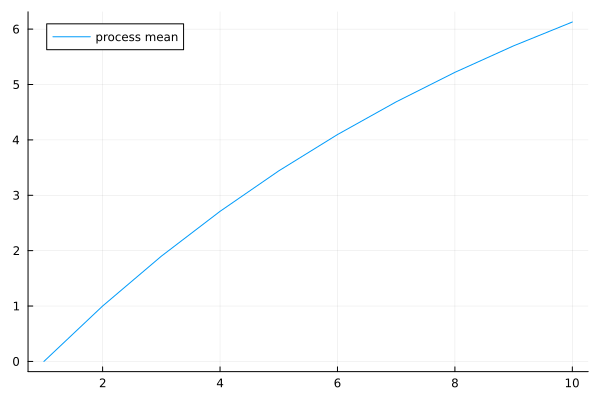

In [18]:
plot([mean(getindex.(sim, i)) for i in 1:10]; label="process mean")

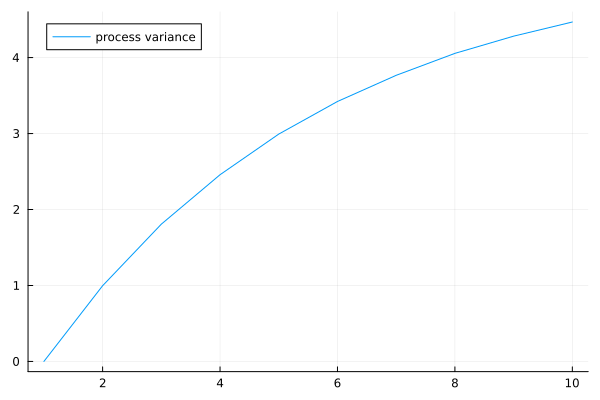

In [19]:
plot([var(getindex.(sim, i)) for i in 1:10]; label="process variance")

### Performance considerations

Let us compare aggregating data with allocations and in-place:

In [20]:
function f1(n::Integer)
    s = zeros(10)
    for i in 1:n
        s .+= ar1(10, 1, 0.9, 1)
    end
    return extrema(s) ./ n
end

f1 (generic function with 1 method)

In [21]:
@time f1(10^8)

(9.999947193705163, 10.000135430338226)

 15.843622 seconds (100.00 M allocations: 13.411 GiB, 11.48% gc time)


Note, in particular, the number of allocations above and time spent in garbage collection.

In [22]:
function f2(n::Integer)
    s = zeros(10)
    v = zeros(10)
    for i in 1:n
        s .+= ar1!(v, 1, 0.9, 1)
    end
    return extrema(s) ./ n
end

f2 (generic function with 1 method)

In [23]:
@time f2(10^8)

  5.681899 seconds (2 allocations: 288 bytes)


(9.999999976489088, 10.000412181147537)

#### Exercise

Rewrite the above code to ensure that the results returned by `f2` are reproducible.

### Note about modules

Modules allow you to add scope to names. Here is what happens if you have name clash:

#### Case 1

In [24]:
sin(1)

0.8414709848078965

In [25]:
sin = 2

LoadError: cannot assign a value to imported variable Base.sin from module Main

#### Case 2

(most problematic)

In [26]:
cos = 2

2

In [27]:
cos(2)

LoadError: MethodError: objects of type Int64 are not callable
Maybe you forgot to use an operator such as [36m*, ^, %, / etc. [39m?

#### Case 3

In [28]:
module AR1_two

export ar1

ar1() = nothing

end # module

Main.AR1_two

In [29]:
using .AR1_two